In [1]:
!pip install segmentation-models-pytorch
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: n

In [28]:
import cv2
import torch
import kagglehub
import numpy as np

from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import v2
import torchvision.transforms.functional as TF
from torchvision.io import decode_image
from torch.utils.data import random_split

from matplotlib import pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm

import os
from glob import glob
import json

import segmentation_models_pytorch as smp

import torchvision

DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
INPUT_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL"
OUTPUT_DIR = "/kaggle/working/weak_masks"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [12]:
def generate_weak_mask_cxr(img_path):
    # 1. carregar
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h, w = img.shape
    img = cv2.resize(img, (512, 512))
    
    img[img < 50] = 255 
    img[img > 180] = 255
    
    # 2. equalização + suavização
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    I = clahe.apply(img)
    I = cv2.GaussianBlur(I, (7,7), 0)
    
    for ang in np.arange(0, 151, 30):
        se = np.zeros((15, 15), np.uint8)
        cv2.ellipse(se, (15//2, 15//2), (15//2, 1), ang, 0, 360, 1, -1)
        I_supp = cv2.morphologyEx(I, cv2.MORPH_OPEN, se)
        I = cv2.min(I, I_supp)
        
    # 3. inverter para que opacidades fiquem claras
    I_inv = cv2.normalize(255 - I, None, 0, 255, cv2.NORM_MINMAX)

    # 4. opções de threshold (escolha uma)
    _, bw = cv2.threshold(I_inv, 127, 255, cv2.THRESH_BINARY)
    
    # 5. limpar regiões fora dos pulmões
    # remove um pequeno pedaço do topo e das laterais que não incluem o pulmão (geralmente)
    bw[:40, :], bw[:, -70:], bw[:, :70] = 0,0, 0
    
    # 6. morfologia para suavizar
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel)
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)
    
    # 7. manter regiões internas
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bw)
    mask_out = np.zeros_like(bw)
    
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        x,y = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP]
        wc,hc = stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]

        # descarta regiões no topo e muito pequenas
        if area > 500 and y > 39:
            mask_out[labels == i] = 255
    
    # 8. voltar ao tamanho original
    mask_out = cv2.resize(mask_out, (w, h))
    return (mask_out > 0).astype(np.uint8)

In [15]:
# QUALITY CONTROL (QC)

def qc_mask(mask):
    # binário 0/255
    mask_bin = (mask > 127).astype(np.uint8)

    if mask_bin.sum() == 0:
        return False
    
    area = mask_bin.mean()  # área normalizada (0–1)
    if area < 0.02 or area > 0.6:
        return False
    
    # 2 maiores componentes (esperado para pulmões)
    num, labels, stats, _ = cv2.connectedComponentsWithStats(mask_bin)
    if num < 3:
        return False
    
    # pegar os 2 maiores componentes
    areas = stats[1:, cv2.CC_STAT_AREA]
    largest_two = sorted(areas)[-2:]
    
    if largest_two[0] < 500 or largest_two[1] < 500:
        return False
    
    return True

In [ ]:
# DATASET COM QC
class SelfSegDatasetQC(Dataset):
    def __init__(self, dataset_path, image_size=None):
        self.image_files = glob(os.path.join(dataset_path, "**", "*.jpeg"), recursive=True)
        
        self.resize_image = v2.Resize((image_size)) if image_size else (lambda x: x)
        self.resize_mask  = v2.Resize((image_size)) if image_size else (lambda x: x)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]

        # imagem  
        img = decode_image(image_path)        # tensor uint8 [1,H,W]
        img = self.resize_image(img)

        # CONVERSÃO ESSENCIAL
        img = img.float() / 255.0             # agora float32 [0..1]

        # weak mask  
        mask_np = generate_weak_mask_cxr(image_path)   # numpy [H,W]
        mask = torch.tensor(mask_np, dtype=torch.float32).unsqueeze(0)
        mask = self.resize_mask(mask)

        return img, mask, image_path

In [17]:
# UNET + LOSS

class DiceBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, pred, target):
        bce = self.bce(pred, target)

        pred = torch.sigmoid(pred)
        smooth = 1e-5

        inter = (pred * target).sum()
        dice = (2 * inter + smooth) / (pred.sum() + target.sum() + smooth)

        return bce + (1 - dice)

In [38]:
# EARLY LEARNING

def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0

    for imgs, masks in loader:
        imgs  = imgs.float()
        masks = masks.float()

        optimizer.zero_grad()

        pred = model(imgs)
        loss = loss_fn(pred, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def early_learning(model, dataset, lr=1e-4, epochs=3, batch=4):
    loader = DataLoader(dataset, batch_size=batch, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()

    model.train()
    for epoch in range(epochs):
        total = 0

        # agora retornam 3 valores
        for imgs, weak_masks, _ in loader:  
            preds = model(imgs)
            loss = criterion(preds, weak_masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total += loss.item()

        print(f"Epoch {epoch+1}: loss = {total/len(loader):.4f}")

    return model

In [53]:
# GERAR PSEUDO-LABELS (MODELO PRODUZ SUAS PRÓPRIAS MÁSCARAS)

from torchvision.utils import save_image
import os
from torch.utils.data import DataLoader

def generate_pseudo_labels(model, dataset, out_dir, threshold=0.5):
    os.makedirs(out_dir, exist_ok=True)

    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    model.eval()
    model.to(device)

    with torch.no_grad():
        for batch in loader:
            imgs, masks, image_path = batch

            # CORREÇÃO AQUI
            imgs = imgs.to(device)

            preds = model(imgs)
            preds = torch.sigmoid(preds)
            mask = (preds > threshold).float().cpu().numpy()[0, 0]

            fname = os.path.basename(image_path[0])
            out_path = os.path.join(out_dir, fname)

            cv2.imwrite(out_path, (mask * 255).astype("uint8"))

In [50]:
# DATASET PARA SELF-LEARNING

class SelfLearningDataset(Dataset):
    def __init__(self, img_dir, mask_dir, image_size=None):
        self.image_files = glob(os.path.join(img_dir, "**", "*.jpeg"), recursive=True)
        self.mask_dir = mask_dir

        self.resize_image = v2.Resize((image_size)) if image_size else (lambda x: x)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        fname = os.path.basename(image_path)

        # imagem
        img = decode_image(image_path)

        if img.ndim == 2:
            img = img.unsqueeze(0)
        
        img = img.float() / 255.0
        img = self.resize_image(img)

        # pseudo mask gerada previamente
        mask_path = os.path.join(self.mask_dir, fname)
        mask = cv2.imread(mask_path, 0)

        if mask is None:
            raise FileNotFoundError(f"Mask not found: {mask_path}")

        mask = torch.tensor(mask / 255.0).float().unsqueeze(0)

        return img, mask, image_path

In [48]:
# SELF-LEARNING (3 epochs)

def self_learning(model, dataset, lr=1e-4, epochs=10, batch=8):
    loader = DataLoader(dataset, batch_size=batch, shuffle=True)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model = model.to(device)

    for ep in range(epochs):
        model.train()
        total_loss = 0

        # <<< agora recebemos 3 valores >>>
        for imgs, pseudo_masks, _ in loader:
            imgs = imgs.to(device)
            pseudo_masks = pseudo_masks.float().to(device)

            preds = model(imgs)
            loss = criterion(preds, pseudo_masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"[Self Learning] Epoch {ep+1}/{epochs}  loss={total_loss/len(loader):.4f}")

    return model

In [25]:
import segmentation_models_pytorch as smp

def create_model():
    return smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=1,
        classes=1,
        activation=None       # sigmoid é feita na loss
    )

In [54]:
# PIPELINE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. weak labels + QC
weak_dataset = SelfSegDatasetQC(INPUT_DIR, image_size=(256,256))

# 2. early learning
model = create_model()
model = early_learning(model, weak_dataset)

# 3. geramos pseudo-labels
generate_pseudo_labels(model, weak_dataset, "/kaggle/working/weak_masks/pseudo_masks")

# 4. carregar pseudo dataset
pseudo_dataset = SelfLearningDataset(INPUT_DIR,
                                     "/kaggle/working/weak_masks/pseudo_masks",
                                     image_size=(256,256))

# 5. self-learning
model = self_learning(model, pseudo_dataset)

# 6. gerar round2
generate_pseudo_labels(
    model, pseudo_dataset,
    "/kaggle/working/weak_masks/pseudo_masks_round2"
)

Epoch 1: loss = 0.4044
Epoch 2: loss = 0.2339
Epoch 3: loss = 0.1856
[Self Learning] Epoch 1/10  loss=0.1331
[Self Learning] Epoch 2/10  loss=0.1150
[Self Learning] Epoch 3/10  loss=0.1082
[Self Learning] Epoch 4/10  loss=0.0964
[Self Learning] Epoch 5/10  loss=0.0873
[Self Learning] Epoch 6/10  loss=0.0793
[Self Learning] Epoch 7/10  loss=0.0718
[Self Learning] Epoch 8/10  loss=0.0700
[Self Learning] Epoch 9/10  loss=0.0689
[Self Learning] Epoch 10/10  loss=0.0671


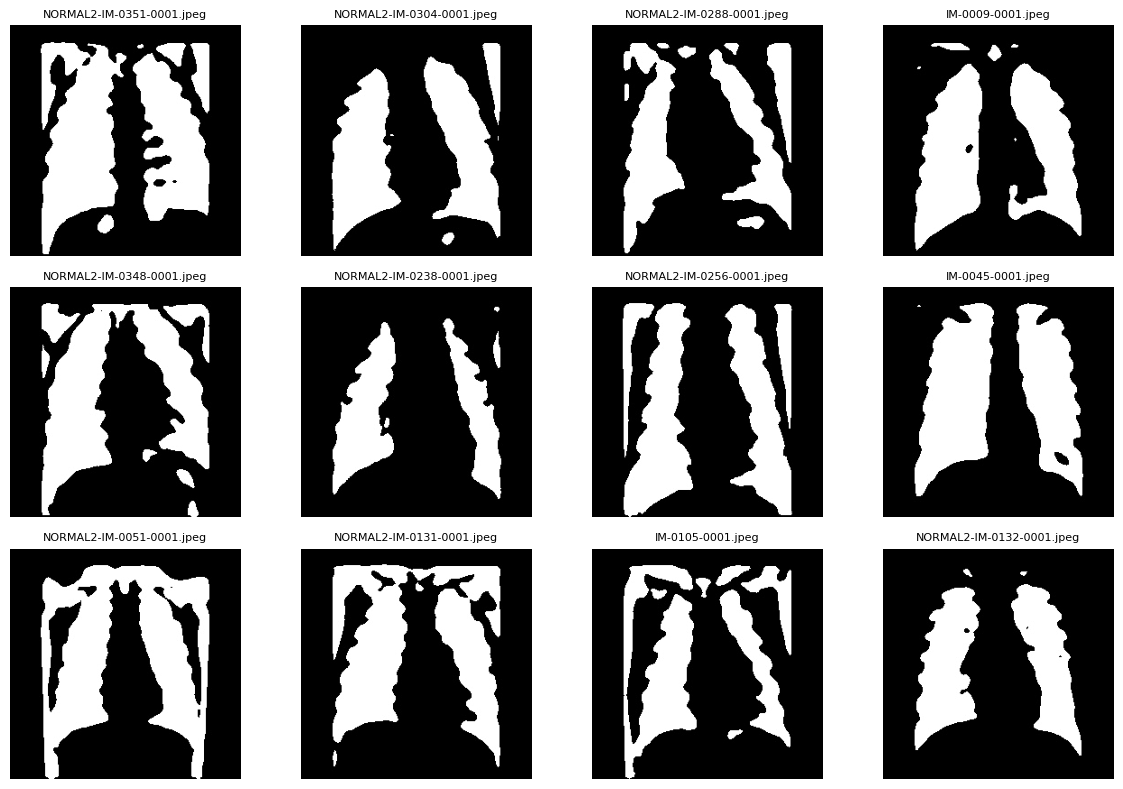

In [55]:
import os
import random
import cv2
import matplotlib.pyplot as plt

mask_dir = "/kaggle/working/weak_masks/pseudo_masks_round2"

# pegar lista de arquivos
mask_files = [f for f in os.listdir(mask_dir) if f.endswith(".jpeg") or f.endswith(".png")]

# quantas quer ver
N = 12
sampled = random.sample(mask_files, min(N, len(mask_files)))

cols = 4
rows = (len(sampled) + cols - 1) // cols

plt.figure(figsize=(12, 8))

for i, fname in enumerate(sampled):
    mask_path = os.path.join(mask_dir, fname)
    mask = cv2.imread(mask_path, 0)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(mask, cmap="gray")
    plt.title(fname, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()
